# Imports and Data 

In [5]:
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from math import *
%matplotlib notebook

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,f1_score
from imblearn.combine import SMOTEENN 

pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_rows", 3000)       

In [6]:
data = pd.read_pickle('./data/struct_dataset.pkl')
data

,Accident_Index,Longitude,Latitude,Date,Day_of_Week,Time,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Accident_Severity,pop_density,count_point_id,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs
0,2018010080971,-0.139737,51.524587,0.017213,9.749279e-01,0.382683,A,Dual carriageway,30 MPH,Not at junction or within 20 metres,Darkness - lights lit,Fine no high winds,Dry,Urban,Slight,97.1,47245,1552.5,3982.0,53957.5,1822.5,14522.0,1678.0
1,2018010080973,0.046471,51.539651,0.017213,9.749279e-01,0.216440,B,Single carriageway,30 MPH,Mini-roundabout,Darkness - lights lit,Fine no high winds,Dry,Urban,Slight,89.8,942818,19.5,5.0,277.5,2.0,46.0,1.0
2,2018010080974,-0.102474,51.529746,0.017213,9.749279e-01,0.195090,A,Single carriageway,20 MPH,Crossroads,Darkness - lights lit,Fine no high winds,Dry,Urban,Slight,149.2,57902,346.0,1302.0,10112.5,358.0,3115.0,603.5
3,2018010080981,0.037828,51.530179,0.017213,9.749279e-01,0.707107,B,Dual carriageway,30 MPH,More than 4 arms (not roundabout),Darkness - lights lit,Raining no high winds,Wet or damp,Urban,Serious,212.0,942818,19.5,5.0,277.5,2.0,46.0,1.0
4,2018010080982,0.065781,51.469258,0.017213,9.749279e-01,0.573576,A,Single carriageway,30 MPH,Not at junction or within 20 metres,Darkness - lights lit,Fine no high winds,Wet or damp,Urban,Serious,15.3,73053,106.5,294.5,14014.0,466.5,2020.5,119.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227936,201963DF02919,-3.094841,52.739912,-0.741222,-2.449294e-16,-0.922201,A,Single carriageway,60 MPH,Not at junction or within 20 metres,Daylight,Fine no high winds,Dry,Rural,Fatal,0.5,812002,23.0,3.0,810.0,13.0,181.0,48.0
227937,201963DF03019,-3.322442,52.335266,-0.826354,7.818315e-01,0.087156,A,Single carriageway,60 MPH,Not at junction or within 20 metres,Daylight,Fine no high winds,Dry,Rural,Fatal,0.1,50547,0.0,50.5,2765.5,21.0,684.5,141.5
227938,201963DF03319,-3.515306,52.506924,-0.993257,7.818315e-01,-0.195090,B,Single carriageway,30 MPH,Not at junction or within 20 metres,Darkness - lights lit,Raining no high winds,Wet or damp,Rural,Fatal,0.1,951275,3.0,5.0,941.5,11.5,175.0,18.5
227939,201963DF03419,-3.651922,52.097790,-0.994218,-2.449294e-16,-0.216440,A,Single carriageway,60 MPH,Not at junction or within 20 metres,Daylight,Fine no high winds,Dry,Rural,Fatal,0.1,20554,0.0,28.0,1642.0,18.5,486.5,239.5


# Feature Engg 

- Divergence of each feature w.r.t. all classes.
- Correlation of each feature pair and with the target classes

## Transforming Traffic Features

In [7]:
data.columns

Index(['Accident_Index', 'Longitude', 'Latitude', 'Date', 'Day_of_Week',
       'Time', '1st_Road_Class', 'Road_Type', 'Speed_limit', 'Junction_Detail',
       'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
       'Urban_or_Rural_Area', 'Accident_Severity', 'pop_density',
       'count_point_id', 'pedal_cycles', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs'],
      dtype='object')

<IPython.core.display.Javascript object>


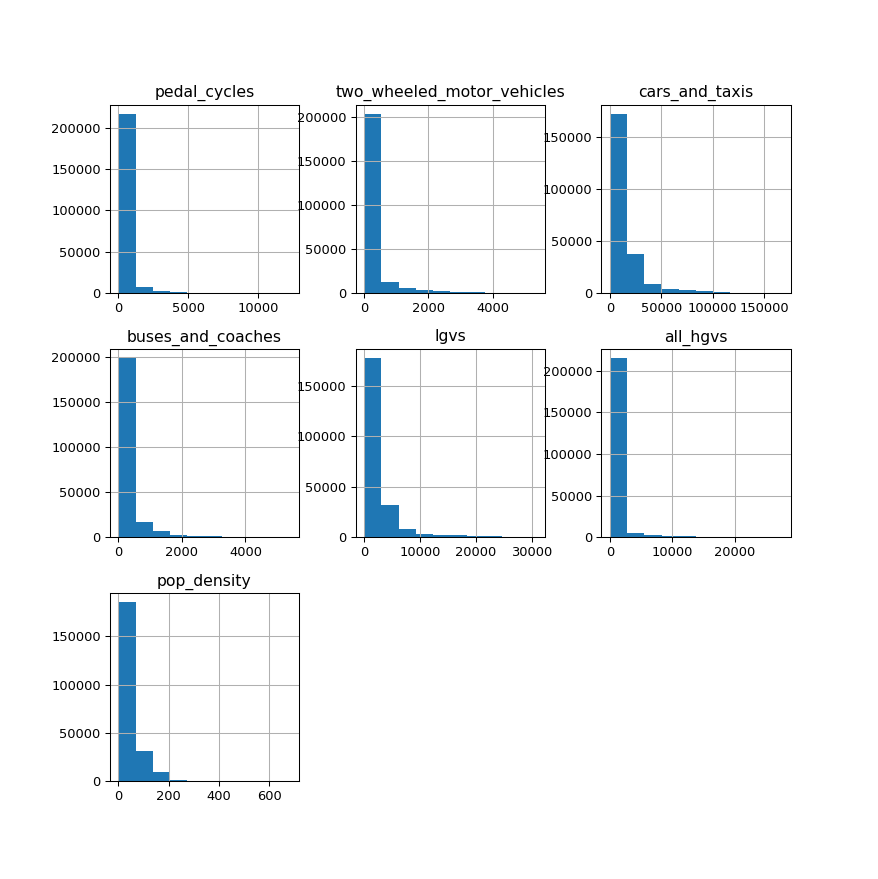

array([[<AxesSubplot:title={'center':'pedal_cycles'}>,
        <AxesSubplot:title={'center':'two_wheeled_motor_vehicles'}>,
        <AxesSubplot:title={'center':'cars_and_taxis'}>],
       [<AxesSubplot:title={'center':'buses_and_coaches'}>,
        <AxesSubplot:title={'center':'lgvs'}>,
        <AxesSubplot:title={'center':'all_hgvs'}>],
       [<AxesSubplot:title={'center':'pop_density'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

In [8]:
data[[
    'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
    'buses_and_coaches', 'lgvs', 'all_hgvs', 'pop_density'
]].hist(figsize=(10,10))

All the numerical traffic based features follow a power-law distribution. Using log transforms on all of these.

In [9]:
data[[
    'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
    'buses_and_coaches', 'lgvs', 'all_hgvs', 'pop_density'
]] = data[[
    'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
    'buses_and_coaches', 'lgvs', 'all_hgvs', 'pop_density'
]].replace(0,0.1)

In [10]:
data[[
    'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
    'buses_and_coaches', 'lgvs', 'all_hgvs', 'pop_density'
]] = data[[
    'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
    'buses_and_coaches', 'lgvs', 'all_hgvs', 'pop_density'
]].apply(lambda x: np.log(x))

<IPython.core.display.Javascript object>


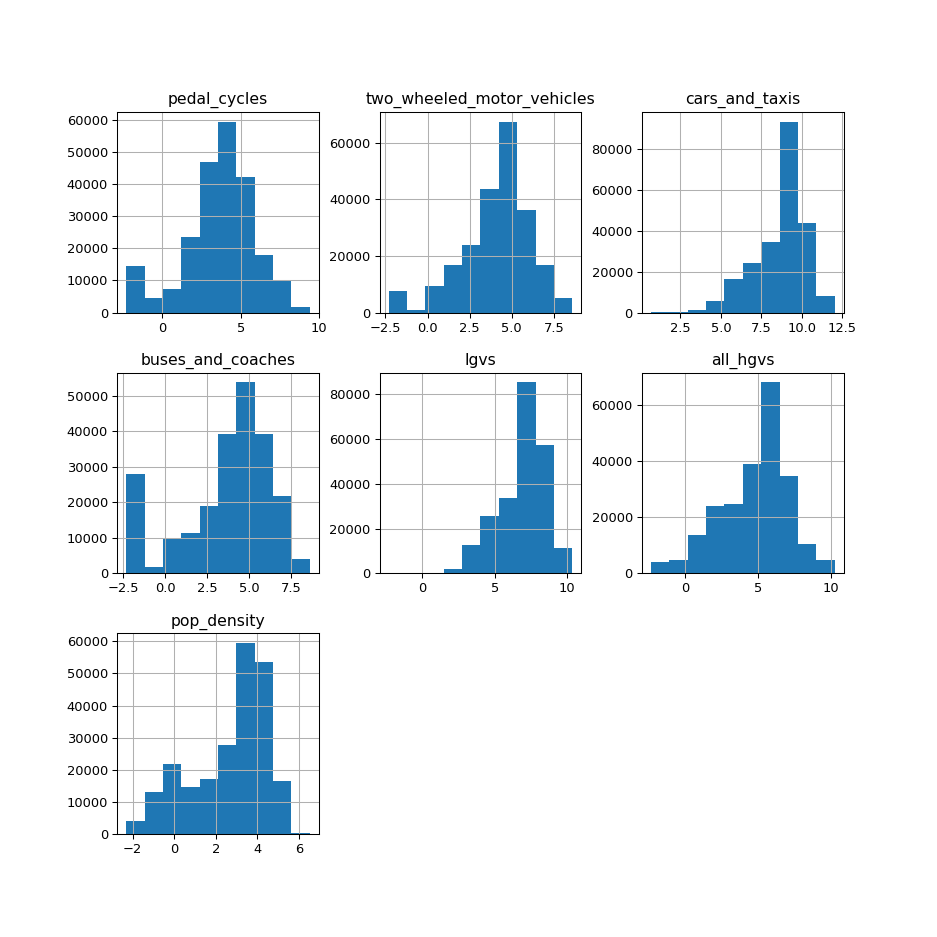

array([[<AxesSubplot:title={'center':'pedal_cycles'}>,
        <AxesSubplot:title={'center':'two_wheeled_motor_vehicles'}>,
        <AxesSubplot:title={'center':'cars_and_taxis'}>],
       [<AxesSubplot:title={'center':'buses_and_coaches'}>,
        <AxesSubplot:title={'center':'lgvs'}>,
        <AxesSubplot:title={'center':'all_hgvs'}>],
       [<AxesSubplot:title={'center':'pop_density'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

In [11]:
data[[
    'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
    'buses_and_coaches', 'lgvs', 'all_hgvs', 'pop_density'
]].hist(figsize=(10,10))

The features now follow a more gaussian distribution

## One-Hot Encoding 

In [12]:
a = pd.get_dummies(data[[
    '1st_Road_Class', 'Road_Type', 'Junction_Detail', 'Light_Conditions',
    'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area'
]],
                   prefix=[
                       '1st_Road_Class', 'Road_Type', 'Junction_Detail',
                       'Light_Conditions', 'Weather_Conditions',
                       'Road_Surface_Conditions', 'Urban_or_Rural_Area'
                   ],
                   drop_first=True)

## Target Variable & Misc.

In [13]:
data[['Accident_Severity']].value_counts()

Accident_Severity
Slight               181445
Serious               43478
Fatal                  3018
dtype: int64

Serious and Fatal accidents are extremely small in ratio as compared to Slight accidents fro obvious reasons. Thus, merging the two to make this a binary classification problem.

In [14]:
data['Accident_Severity'].replace(to_replace = 'Fatal', value = 'Serious', inplace=True)

In [15]:
data[['Accident_Severity']].value_counts()

Accident_Severity
Slight               181445
Serious               46496
dtype: int64

In [16]:
data['Speed_limit'] = data['Speed_limit'].apply(lambda x: int(x[:2]))

In [17]:
data.columns

Index(['Accident_Index', 'Longitude', 'Latitude', 'Date', 'Day_of_Week',
       'Time', '1st_Road_Class', 'Road_Type', 'Speed_limit', 'Junction_Detail',
       'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
       'Urban_or_Rural_Area', 'Accident_Severity', 'pop_density',
       'count_point_id', 'pedal_cycles', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs'],
      dtype='object')

In [31]:
model_data = pd.concat([
    data[[
        'Longitude', 'Latitude', 'Date', 'Day_of_Week', 'Time', 'Speed_limit',
        'pop_density', 'pedal_cycles', 'two_wheeled_motor_vehicles',
        'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs'
    ]], a, data['Accident_Severity']
],
                       axis=1)
model_data['Accident_Severity'].replace(to_replace=['Slight', 'Serious'],
                                        value=[0, 1],
                                        inplace=True)
model_data

,Longitude,Latitude,Date,Day_of_Week,Time,Speed_limit,pop_density,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,1st_Road_Class_B,1st_Road_Class_C,1st_Road_Class_Motorway,1st_Road_Class_Unclassified,Road_Type_One way street,Road_Type_Roundabout,Road_Type_Single carriageway,Road_Type_Slip road,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 metres,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,Junction_Detail_Roundabout,Junction_Detail_Slip road,Junction_Detail_T or staggered junction,Light_Conditions_Darkness - lights lit,Light_Conditions_Darkness - lights unlit,Light_Conditions_Darkness - no lighting,Light_Conditions_Daylight,Weather_Conditions_Fine no high winds,Weather_Conditions_Fog or mist,Weather_Conditions_Other,Weather_Conditions_Raining + high winds,Weather_Conditions_Raining no high winds,Weather_Conditions_Snowing + high winds,Weather_Conditions_Snowing no high winds,Road_Surface_Conditions_Flood over 3cm. deep,Road_Surface_Conditions_Frost or ice,Road_Surface_Conditions_Snow,Road_Surface_Conditions_Wet or damp,Urban_or_Rural_Area_Urban,Accident_Severity
0,-0.139737,51.524587,0.017213,9.749279e-01,0.382683,30,4.575741,7.347622,8.289539,10.895952,7.507964,9.583420,7.425358,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0.046471,51.539651,0.017213,9.749279e-01,0.216440,30,4.497585,2.970414,1.609438,5.625821,0.693147,3.828641,0.000000,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,-0.102474,51.529746,0.017213,9.749279e-01,0.195090,20,5.005288,5.846439,7.171657,9.221528,5.880533,8.043984,6.402746,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0.037828,51.530179,0.017213,9.749279e-01,0.707107,30,5.356586,2.970414,1.609438,5.625821,0.693147,3.828641,0.000000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1
4,0.065781,51.469258,0.017213,9.749279e-01,0.573576,30,2.727853,4.668145,5.685279,9.547812,6.145258,7.611100,4.783316,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227936,-3.094841,52.739912,-0.741222,-2.449294e-16,-0.922201,60,-0.693147,3.135494,1.098612,6.697034,2.564949,5.198497,3.871201,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
227937,-3.322442,52.335266,-0.826354,7.818315e-01,0.087156,60,-2.302585,-2.302585,3.921973,7.924977,3.044522,6.528689,4.952300,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
227938,-3.515306,52.506924,-0.993257,7.818315e-01,-0.195090,30,-2.302585,1.098612,1.609438,6.847474,2.442347,5.164786,2.917771,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
227939,-3.651922,52.097790,-0.994218,-2.449294e-16,-0.216440,60,-2.302585,-2.302585,3.332205,7.403670,2.917771,6.187237,5.478553,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1


## Scaling & Splitting

In [32]:
x = pd.DataFrame(MinMaxScaler().fit_transform(model_data[model_data.columns[:-1]]), columns=model_data.columns[:-1])
y = model_data['Accident_Severity']

In [33]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=1 - train_ratio,
                                                    stratify=y)
x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=test_ratio / (test_ratio + validation_ratio),
    stratify=y_test)

In [34]:
y_train.value_counts(normalize=True)

0    0.796021
1    0.203979
Name: Accident_Severity, dtype: float64

In [35]:
y_test.value_counts(normalize=True)

0    0.796003
1    0.203997
Name: Accident_Severity, dtype: float64

In [36]:
y_val.value_counts(normalize=True)

0    0.796021
1    0.203979
Name: Accident_Severity, dtype: float64

# Model Fitting 

Due to the majority of one-hot encoded features (32:47), a decision tree based approach suits the dataset the best. **Theory for Light-GBM** 

In [37]:
def perf_measure(y_actual, y_pred):
    eval_dict = {}
    cm = metrics.confusion_matrix(y_actual, y_pred)
    TN = cm[0][0]
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    prfs = metrics.precision_recall_fscore_support(y_actual, y_pred)
    eval_dict['Recall'] = [
        metrics.recall_score(y_actual, y_pred), prfs[1][0], prfs[1][1]
    ]
    eval_dict['Precision'] = [
        metrics.precision_score(y_actual, y_pred), prfs[0][0], prfs[0][1]
    ]
    eval_dict['False_Positive_Rate'] = [FP / prfs[3][0]]
    eval_dict['False_Negative_Rate'] = [FN / prfs[3][1]]
    eval_dict['F1_Score'] = [
        metrics.f1_score(y_actual, y_pred), prfs[2][0], prfs[2][1]
    ]
    eval_dict['Accuracy'] = [
        metrics.accuracy_score(y_actual, y_pred), TN / prfs[3][0],
        TP / prfs[3][1]
    ]
    return pd.DataFrame(eval_dict, index=['Overall', 0, 1]) * 100


## LGBM 

In [38]:
def lgbm_model(lgb_train, lgb_test, num_boost_round, cutoff, early_stopping_rounds):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "num_leaves": 20, #20
        "max_depth": 5,   #5
        #"lambda_l1": 5,
        "lambda_l2": 15,
        "learning_rate": 0.01,
        "bagging_fraction": 0.7,
        "feature_fraction": 0.7,
        "bagging_freq": 5,
        "bagging_seed": 2020,
        "verbosity": -1
    }
    evals_result = {}
    lgbmodel = lgb.train(params,
                         lgb_train,
                         num_boost_round,
                         valid_sets=[lgb_train, lgb_valid],
                         evals_result=evals_result,
                         early_stopping_rounds=early_stopping_rounds,
                         verbose_eval=100)
    print('Plot metrics during training...')
    ax = lgb.plot_metric(evals_result,
                         metric='binary_logloss',
                         figsize=(10, 5))
    plt.show()
    preds_train = lgbmodel.predict(x_train,
                                   num_iteration=lgbmodel.best_iteration)
    preds_val = lgbmodel.predict(x_val,
                                 num_iteration=lgbmodel.best_iteration)
    p_train = np.where(preds_train > cutoff, 1, 0)
    p_val = np.where(preds_val > cutoff, 1, 0)
    print(" Train Recall Score := ", metrics.recall_score(y_train, p_train))
    print(" val Recall Score := ", metrics.recall_score(y_val, p_val))
    print(" Train Precision Score := ",
          metrics.precision_score(y_train, p_train))
    print(" val Precision Score := ", metrics.precision_score(y_val, p_val))
    print(" Train AUC-ROC Score := ", metrics.roc_auc_score(y_train, p_train))
    print(" val AUC-ROC Score := ", metrics.roc_auc_score(y_val, p_val))
    print(" Train F1 Score := ", metrics.f1_score(y_train, p_train))
    print(" val F1 Score := ", metrics.f1_score(y_val, p_val))
    auc_score = metrics.roc_auc_score(y_val, p_val)
    round(float(auc_score), 2)
    fpr, tpr, threshold = metrics.roc_curve(y_val,
                                            p_val,
                                            drop_intermediate=False)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % auc_score)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    lgb.plot_importance(lgbmodel, max_num_features=25, figsize=(10, 5))
    return lgbmodel, p_val, preds_train, preds_val

In [39]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_val, y_val, reference=lgb_train)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.497141	valid_1's binary_logloss: 0.497524
[200]	training's binary_logloss: 0.494042	valid_1's binary_logloss: 0.494921
[300]	training's binary_logloss: 0.492406	valid_1's binary_logloss: 0.493852
[400]	training's binary_logloss: 0.49108	valid_1's binary_logloss: 0.493058
[500]	training's binary_logloss: 0.49	valid_1's binary_logloss: 0.492525
[600]	training's binary_logloss: 0.489044	valid_1's binary_logloss: 0.492174
[700]	training's binary_logloss: 0.488183	valid_1's binary_logloss: 0.491905
[800]	training's binary_logloss: 0.487367	valid_1's binary_logloss: 0.491695
[900]	training's binary_logloss: 0.486605	valid_1's binary_logloss: 0.491521
[1000]	training's binary_logloss: 0.485876	valid_1's binary_logloss: 0.491426
[1100]	training's binary_logloss: 0.48518	valid_1's binary_logloss: 0.491352
[1200]	training's binary_logloss: 0.484497	valid_1's binary_logloss: 0.491288
[1300]	training's

<IPython.core.display.Javascript object>


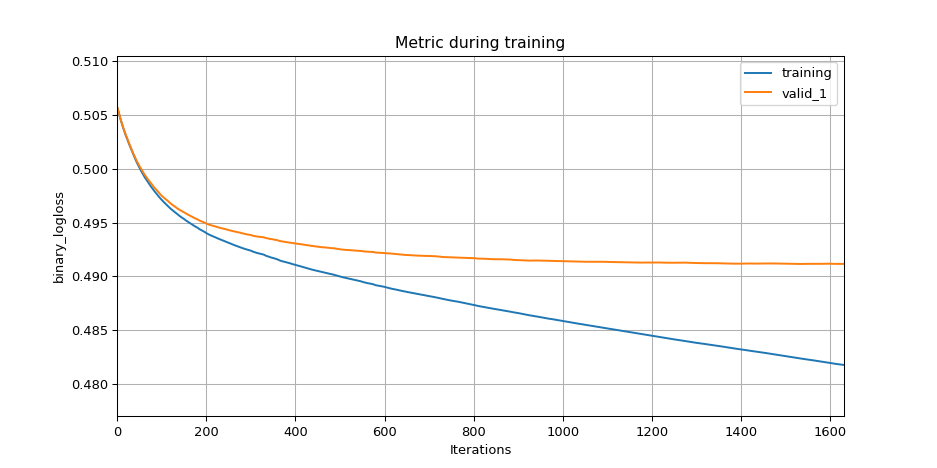

 Train Recall Score :=  0.5925726780657419
 val Recall Score :=  0.5511345305946876
 Train Precision Score :=  0.2905476659167604
 val Precision Score :=  0.27109230362338005
 Train AUC-ROC Score :=  0.6108995827155296
 val AUC-ROC Score :=  0.5857025680061536
 Train F1 Score :=  0.389914261790478
 val F1 Score :=  0.3634236278542051


<IPython.core.display.Javascript object>


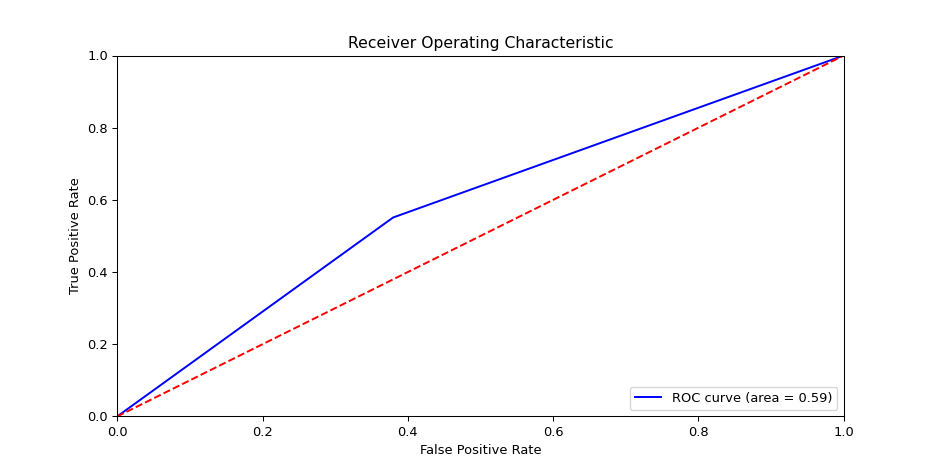

<IPython.core.display.Javascript object>


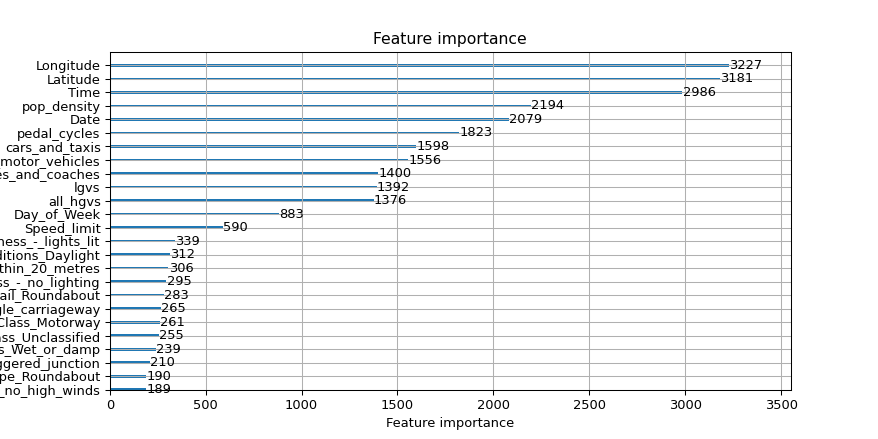

In [40]:
lgb_model, val_pred, preds_train, preds_val = lgbm_model(lgb_train, lgb_valid, 2000, 0.2038, 100)

In [49]:
sns.distplot(preds_train)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

In [45]:
print(preds_train.mean())
print(np.median(preds_train))

0.20379663260253078
0.19068821412427261


In [46]:
sns.distplot(preds_val)
print(preds_val.mean())
print(np.median(preds_val))

0.20352472342073671
0.19034266457651627


Looking at the distribution of prediction probabilities of the model, it is clear that due to the extreme class imbalance, the values are heavily skewed towards smaller values tending to 0 rather than 1. The mean of this right-tailed distribution is 0.2038. Thus, shifting the probability cut-off for classification from 0.5 to 0.2038, the following results are achieved. 

## Evaluation 

In [51]:
preds = lgb_model.predict(x_test)
print(preds)
sns.distplot(preds)
print(preds.mean())

[0.14090273 0.10971652 0.20739575 ... 0.23412042 0.19701758 0.14836447]
0.20412960499585736


In [52]:
a = np.where(preds>0.5, 1, 0)
print(classification_report(y_test, a))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     36289
           1       0.50      0.00      0.00      9300

    accuracy                           0.80     45589
   macro avg       0.65      0.50      0.44     45589
weighted avg       0.74      0.80      0.71     45589



In [53]:
perf_measure(y_test, a)

,Recall,Precision,False_Positive_Rate,False_Negative_Rate,F1_Score,Accuracy
Overall,0.043011,50.000000,0.011023,99.956989,0.085948,79.600342
0,99.988977,79.605537,0.011023,99.956989,88.640528,99.988977
1,0.043011,50.000000,0.011023,99.956989,0.085948,0.043011


In [54]:
a = np.where(preds>0.2038, 1, 0)
perf_measure(y_test, a)

,Recall,Precision,False_Positive_Rate,False_Negative_Rate,F1_Score,Accuracy
Overall,54.655914,26.655829,38.540605,45.344086,35.834890,60.071508
0,61.459395,84.098793,38.540605,45.344086,71.018485,61.459395
1,54.655914,26.655829,38.540605,45.344086,35.834890,54.655914


The results remain poor, specifically the F1 score for the 'Serious' accidents class. The F1 score improves after altering the cut-off for the decision boundary from 0.5 to 0.2038 but still remains at 36% for Class-1. This is indicative of the poor performance and lack of generalisability of the model for class-1 due to the lack of data. 

## SMOTE + ENN based Up - Sampling & improving class separability  

Synthetic Minority Over-sampling Technique (SMOTE) () is an over-sampling method. Its main idea is to
form new minority class examples by interpolating between several minority class examples that lie together. <br>
Thus, the over-fitting problem is avoided and causes the decision boundaries for the minority class to spread further into the majority class space. <br>
But the over-sampling of minority classes may only work in the case when all the classes are not skewed and don't extend into the other classes. In the case that either of the majority or minority classes skew into the other ones, SMOTE would in fact lead to much poor performance of the classifier as it would add more noise into the previously well classified majority classes. <br>
To avoid this, an improved version of Tomek link () removal is used - ENN. ENN removes any example that is misclassified by its three nearest neighbors.

In [59]:
smeen = SMOTEENN()
x_train_smeen = pd.concat([x_train, x_val])
y_train_smeen = pd.concat([y_train, y_val])
x_train_smeen, y_train_smeen = smeen.fit_resample(x_train, y_train)

In [60]:
y_train_smeen.value_counts(normalize=True)

1    0.677631
0    0.322369
Name: Accident_Severity, dtype: float64

In [63]:
x_train_smeen, x_val_smeen, y_train_smeen, y_val_smeen = train_test_split(
    x_train_smeen, y_train_smeen, test_size=0.25, stratify=y_train_smeen)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.54467	valid_1's binary_logloss: 0.546482
[200]	training's binary_logloss: 0.507718	valid_1's binary_logloss: 0.51034
[300]	training's binary_logloss: 0.481058	valid_1's binary_logloss: 0.484083
[400]	training's binary_logloss: 0.46154	valid_1's binary_logloss: 0.464897
[500]	training's binary_logloss: 0.444999	valid_1's binary_logloss: 0.448823
[600]	training's binary_logloss: 0.43002	valid_1's binary_logloss: 0.434214
[700]	training's binary_logloss: 0.416747	valid_1's binary_logloss: 0.421354
[800]	training's binary_logloss: 0.407103	valid_1's binary_logloss: 0.412069
[900]	training's binary_logloss: 0.399382	valid_1's binary_logloss: 0.404698
[1000]	training's binary_logloss: 0.394043	valid_1's binary_logloss: 0.399801
[1100]	training's binary_logloss: 0.3884	valid_1's binary_logloss: 0.394609
[1200]	training's binary_logloss: 0.383894	valid_1's binary_logloss: 0.390529
[1300]	training's

<IPython.core.display.Javascript object>


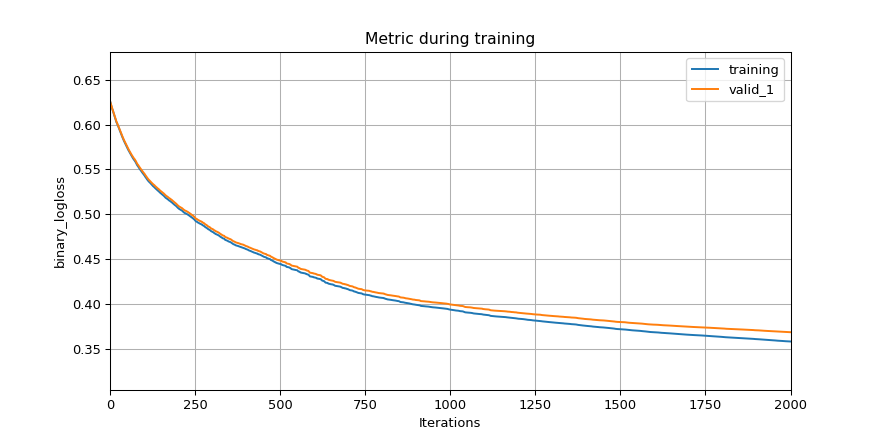

 Train Recall Score :=  0.5360074559988529
 val Recall Score :=  0.5183353048714916
 Train Precision Score :=  0.26225051738047633
 val Precision Score :=  0.25255436206444853
 Train AUC-ROC Score :=  0.574809279727682
 val AUC-ROC Score :=  0.5626204893835812
 Train F1 Score :=  0.35218748159924634
 val F1 Score :=  0.33962795941375423


<IPython.core.display.Javascript object>


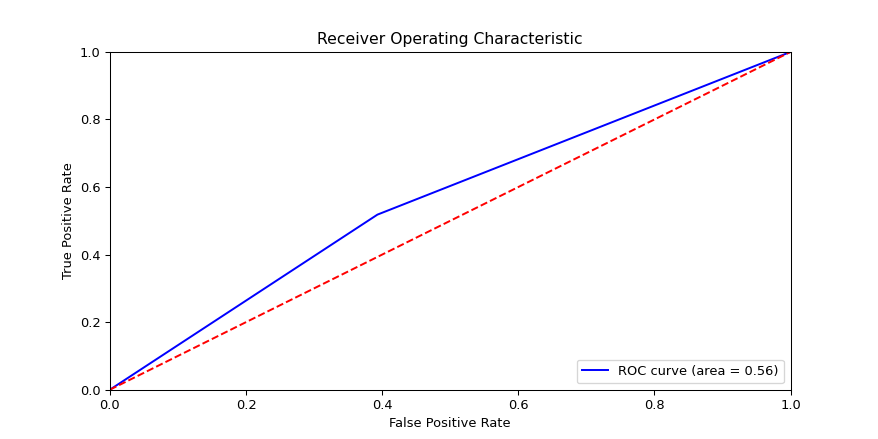

<IPython.core.display.Javascript object>


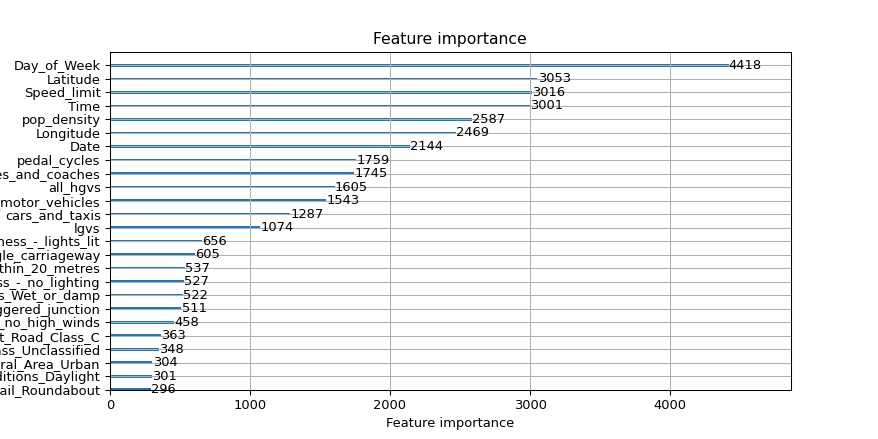

In [64]:
lgb_train = lgb.Dataset(x_train_smeen, y_train_smeen)
lgb_valid = lgb.Dataset(x_val_smeen, y_val_smeen, reference=lgb_train)

lgb_model, val_pred, preds_train, preds_val = lgbm_model(lgb_train, lgb_valid, 2000, 0.5, 100)

## Evaluation 

In [65]:
preds = lgb_model.predict(x_test)
print(preds)
sns.distplot(preds)
print(preds.mean())

[0.16554588 0.21321408 0.57201114 ... 0.52818677 0.46573805 0.38761552]
0.4646809628742944


In [70]:
a = np.where(preds>0.5, 1, 0)
print(classification_report(y_test, a))

              precision    recall  f1-score   support

           0       0.83      0.61      0.70     36289
           1       0.25      0.52      0.34      9300

    accuracy                           0.59     45589
   macro avg       0.54      0.56      0.52     45589
weighted avg       0.71      0.59      0.63     45589



In [71]:
perf_measure(y_test, a)

,Recall,Precision,False_Positive_Rate,False_Negative_Rate,F1_Score,Accuracy
Overall,51.88172,25.219527,39.42517,48.11828,33.940630,58.801465
0,60.57483,83.085762,39.42517,48.11828,70.066618,60.574830
1,51.88172,25.219527,39.42517,48.11828,33.940630,51.881720


In [72]:
a = np.where(preds>0.46, 1, 0)
perf_measure(y_test, a)

,Recall,Precision,False_Positive_Rate,False_Negative_Rate,F1_Score,Accuracy
Overall,59.526882,24.272185,47.59569,40.473118,34.483618,53.857290
0,52.404310,83.477459,47.59569,40.473118,64.388014,52.404310
1,59.526882,24.272185,47.59569,40.473118,34.483618,59.526882


Even after removing the noisy samples from each class that reduced class separability, and oversampling the minority class, the results show that the overall F1 score hasn't improved by a significant amount. The method of oversampling by adding additional scaled datum-vectors along the mid-points of pairs of vectors belonging to the minority class only works when the inherent distribution of the class is regularly distributed in a well defined region, already represented/occupied by the limited available datums. Additionally, even after oversampling the minority classes, the ratio of class-1 samples against class-0 samples only improves by a slight margin. This is because EEN removes noisy samples that reduce class separability from both the classes irrespective of their ratio against the others. This indicates that oversampling caused a huge number of samples to be generated in the space already occupied by the distribution of the majority class (class-0). Thus, almost zero-to-none information was added to the minority class for the classifier to improve on and the results remained the same. <br>
This is indicative of the fact that the information/data available is not fit for a generalizable classification task, unless coupled with more features or additional datums. 

# Improvements 

Due to data in-availability of a particular class, the model performance suffers due to poor generalizability. Also, this data is only valid for a datum that has encountered either a 'Slight' or a 'Severe' accident. This doesn't include the cases for no accidents. 

Since the coordinates for all accident locations, separated by the severity of the event, have been provided by data.gov.uk, these locations are used in order to obtain the coordinates of the remaining 'Safe' locations to add a relevant class to the dataset. Since the only known information/ features are available for the accident locations, a different dataset must be created that provides information not only for the accident events, but for safe locations as well. 